In [2]:
import pandas as pd
import numpy as np

In [3]:
flats_df = pd.read_csv("EKB/EKB_addr_area_price_lon_lat.csv", sep=",")

In [4]:
flats_df.head()

,address,area,price,longtitude,latitude
0,"Екатеринбург, ул. Белинского, 108",84.4,82701,56.819695,60.618172
1,"Екатеринбург, ул. Тверитина, 46",48.6,123045,56.821868,60.620094
2,"Екатеринбург, мкр. Светлый, стр. 7",39.2,62500,56.779136,60.703610
3,"Екатеринбург, ул. Евгения Савкова, д. 35",62.5,62560,56.789333,60.490000
4,"Екатеринбург, ул. Ирбитская, стр. 5",74.2,69542,56.861377,60.657572


In [5]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

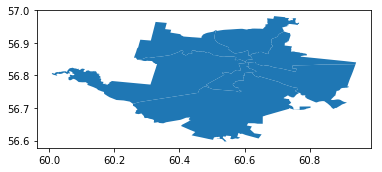

In [6]:
distr_map = gpd.read_file('exportsh/EKB/Верх-Исетский район_AL9.shp', encoding="utf-8")
distr_map.plot()

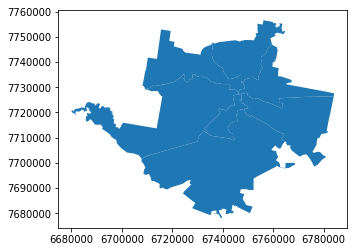

In [7]:
crs = {"init": "epsg:3857"}
distr_map_ep = distr_map.to_crs(crs)
distr_map_ep.plot()

In [8]:
points = [Point(xy) for xy in zip(flats_df.latitude.astype(float), flats_df.longtitude.astype(float))]
crs = {'init' :'epsg:4326'}
flats_geo = GeoDataFrame(flats_df, geometry=points, crs=crs)
flats_geo_ep = flats_geo.to_crs({"init": "epsg:3857"})

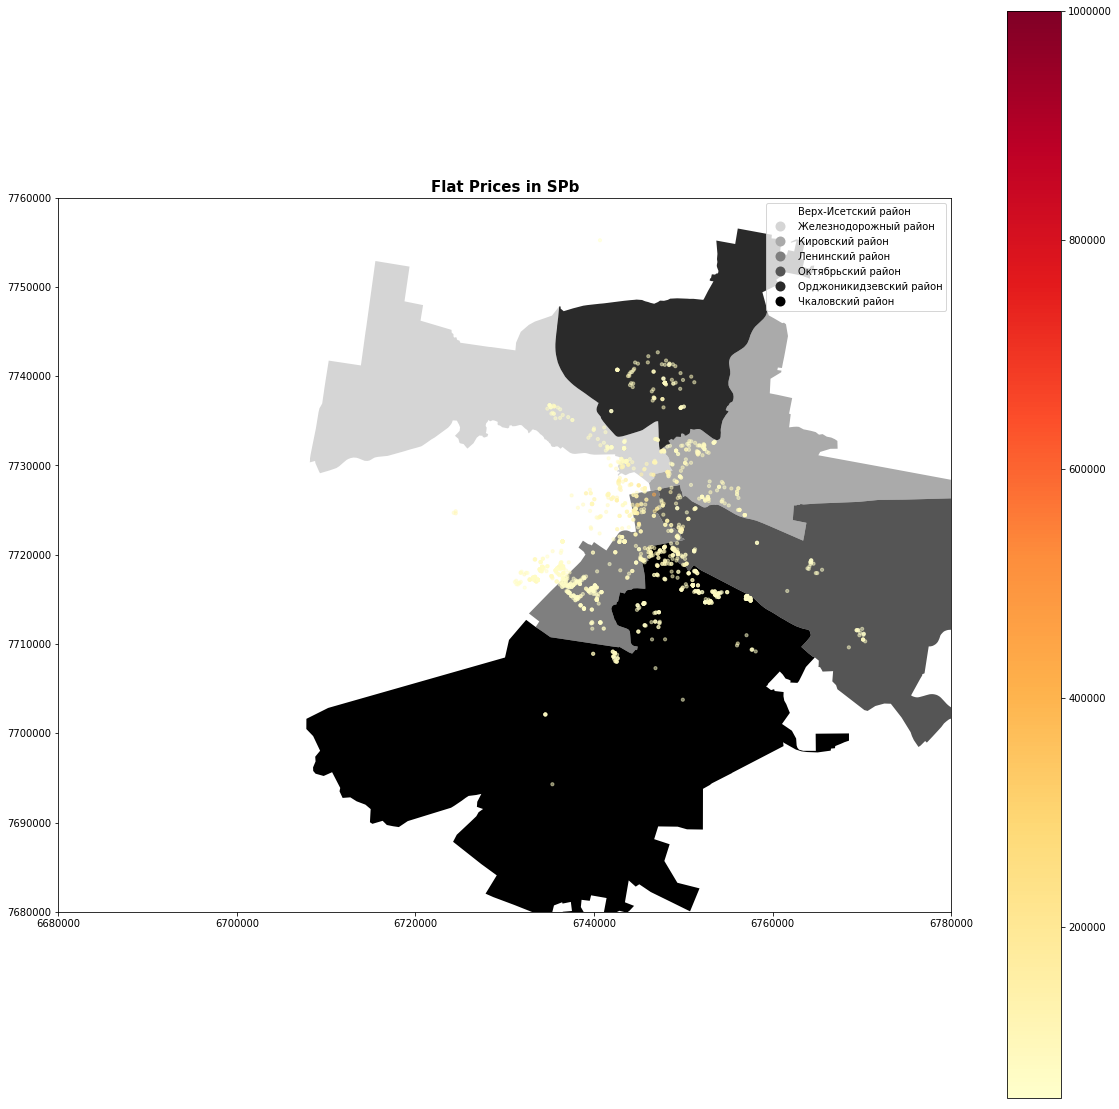

In [9]:
fig, ax = plt.subplots(figsize=(20,20))
distr_map_ep.plot(ax=ax, column = 'locname', linewidth=0.5, cmap='binary', legend=True)
flats_geo_ep.plot(column="price",ax=ax, alpha=0.5, legend=True, markersize=10, cmap="YlOrRd", vmin=50000, vmax=1000000)
plt.title("Flat Prices in SPb", fontsize=15, fontweight="bold")
plt.ylim(7680000,7760000)
plt.xlim( 6680000,6780000)
plt.show()

In [10]:
count_price = {}

for point in flats_geo.geometry:    
    for i, geometry in enumerate(distr_map.geometry):
        if point.within(geometry):
            if count_price.get(distr_map.locname[i], None) is None:
                count_price[distr_map.locname[i]] = [flats_geo.price[i]]
            else:
                count_price[distr_map.locname[i]].append(flats_geo.price[i])

In [11]:
from functools import reduce

aver_price = {}
for k, lst in count_price.items():
    aver_price[k] = reduce(lambda a, b: a + b, lst) / len(lst) 
    
#aver_price

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

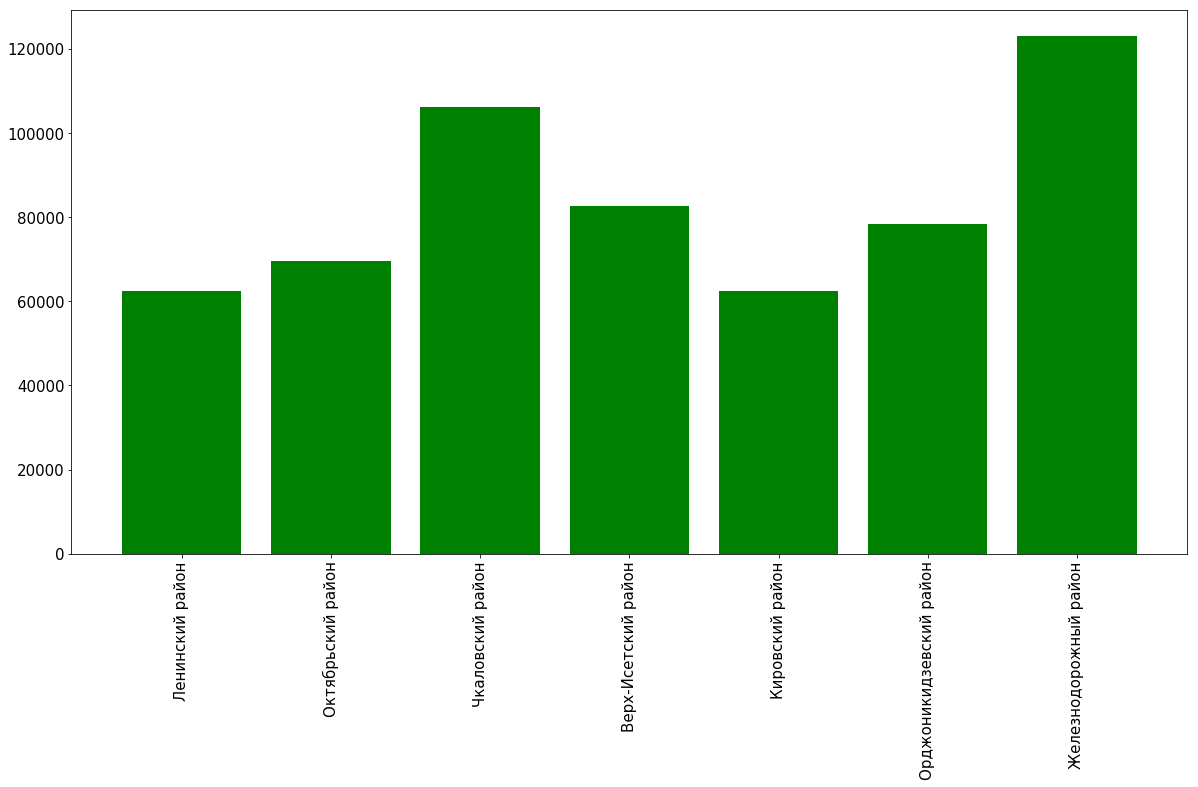

In [12]:
plt.figure(figsize=(20,10))
plt.bar(aver_price.keys(), aver_price.values(), color='g')
plt.tick_params(labelsize=15)
plt.xticks(rotation=90)

In [13]:
#  Визуализация по средней площади квартиры

In [14]:
count_area = {}

for point in flats_geo.geometry:    
    for i, geometry in enumerate(distr_map.geometry):
        if point.within(geometry):
            if count_area.get(distr_map.locname[i], None) is None:
                count_area[distr_map.locname[i]] = [flats_geo["area"][i]]
            else:
                count_area[distr_map.locname[i]].append(flats_geo["area"][i])

In [15]:
aver_area = {}

for k, lst in count_area.items():
    aver_area[k] = reduce(lambda a, b: a + b, lst) / len(lst) 
    
#aver_area

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

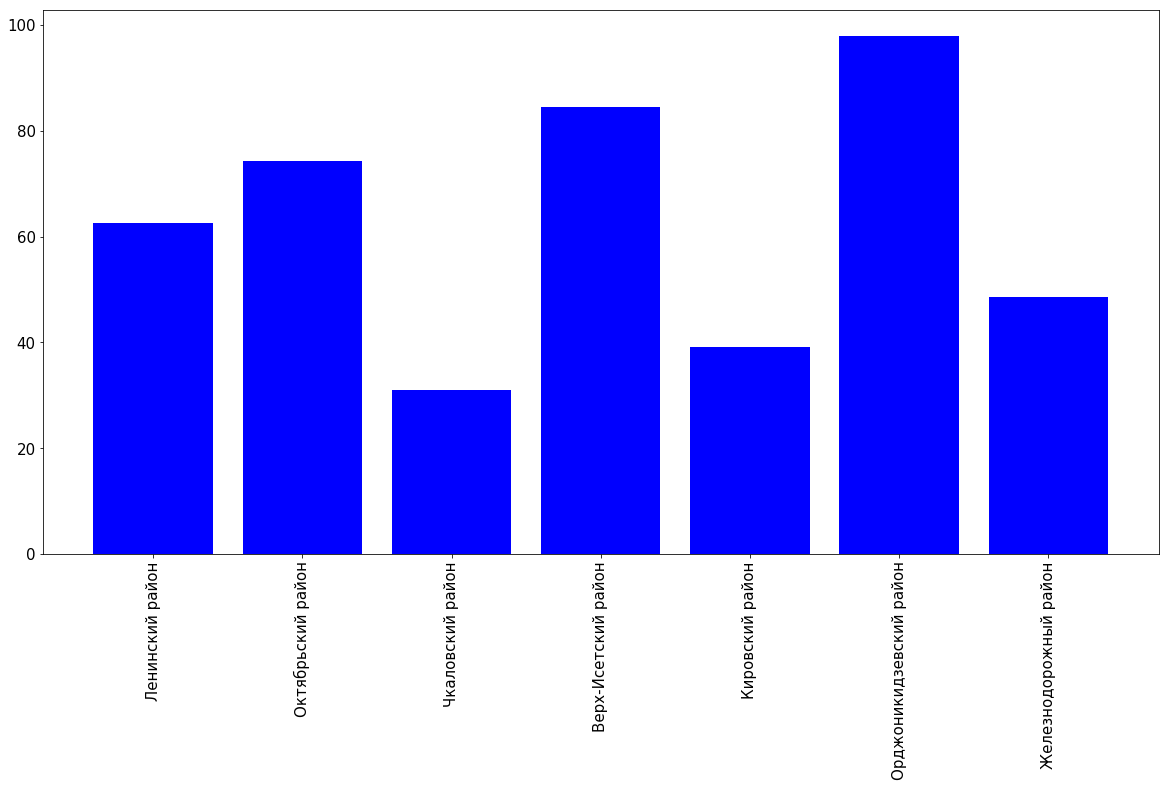

In [16]:
plt.figure(figsize=(20,10))
plt.bar(aver_area.keys(), aver_area.values(), color='b')
plt.tick_params(labelsize=15)
plt.xticks(rotation=90)

In [17]:
# Визуализация с помощью folium

In [18]:
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

In [19]:
def data_unq(df):
    l_addr = len(df.address.unique())
    l_lon = len(df.longtitude.unique())
    l_lat = len(df.latitude.unique())
    l_price = len(df.price.unique())
    print(f"l_addr: {l_addr}, l_lon: {l_lon}, l_lat: {l_lat}, l_price: {l_price}")

data_unq(flats_df)

l_addr: 939, l_lon: 678, l_lat: 677, l_price: 1344


In [20]:
max_price = float(flats_df.price.max())
min_price = float(flats_df.price.min())
max_price, min_price

(437736.0, 34783.0)

In [21]:
location = [56.819695, 60.618172]
mymap = folium.Map(location=location, zoom_start=10)
mc = MarkerCluster()
lon, lat = 'longtitude', 'latitude'

for _, row in flats_df.iterrows():
    mc.add_child(folium.Marker(location=[row[lon], row[lat]]))
    mymap.add_child(mc)
mymap

In [22]:
lon = flats_df.longtitude.values.astype(float)
lat = flats_df.latitude.values.astype(float)
price = flats_df.price.values.astype(float)
lat, lon, price
l_data = list(zip(lon, lat, price))
#l_data

In [23]:
hmap = HeatMap(l_data, min_opacity=0.2, max_val=max(price), radius=10, blur=10, max_zoom=1,)
hmap.add_to(mymap)
mymap

In [ ]:
#hmap = HeatMap(l_data, max_val=max(price)*0.7, radius=5, blur=15, min_opacity=0.2)
#hmap.add_to(mymap)
#mymap